# Exploratory Data Analysis of Zillow Data Set

The data:

* properties_2017.csv is a sample of all properties from 2017 listed on Zillow through Sept
* train_2017.csv contains dates, propertyids, and logerror for each transaction in 2017 through Sept
* The same files are available for 2016 (entire year)
* Not all properties have transactions
* logerror=log(Zestimate)−log(SalePrice)

In [40]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import geopy


In [41]:
df17 = pd.read_csv('properties_2017.csv', low_memory=False)
df_transactions17 = pd.read_csv('train_2017.csv', low_memory=False)
df_merged17 = pd.merge(df17, df_transactions17, on='parcelid', how='right')
df_merged17.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17054981,NaN,NaN,NaN,5.0,4.0,NaN,NaN,5.0,NaN,...,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,NaN,6.111001e+13,-0.013099,2017-06-15
1,17055743,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,66.0,...,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,NaN,6.111001e+13,0.073985,2017-07-26
2,17068109,NaN,NaN,NaN,1.5,3.0,NaN,NaN,1.5,66.0,...,193413.0,286606.0,2016.0,93193.0,2987.36,NaN,NaN,6.111001e+13,0.071886,2017-07-28
3,17073952,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,...,90357.0,258888.0,2016.0,168531.0,2706.24,NaN,NaN,6.111002e+13,0.305680,2017-06-02
4,17078502,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,148752.0,592930.0,2016.0,444178.0,6220.70,NaN,NaN,6.111002e+13,-0.073787,2017-07-07


In [3]:
df16 = pd.read_csv('properties_2016.csv', low_memory=False)
df_transactions16 = pd.read_csv('train_2016_v2.csv', low_memory=False)
df_merged16 = pd.merge(df16, df_transactions16, on='parcelid', how='right')
df_merged16.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111002e+13,0.0953,2016-01-27
1,17088994,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,143809.0,239679.0,2015.0,95870.0,2581.30,NaN,NaN,6.111002e+13,0.0198,2016-03-30
2,17100444,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,33619.0,47853.0,2015.0,14234.0,591.64,NaN,NaN,6.111001e+13,0.0060,2016-05-27
3,17102429,NaN,NaN,NaN,1.5,2.0,NaN,NaN,1.5,NaN,...,45609.0,62914.0,2015.0,17305.0,682.78,NaN,NaN,6.111001e+13,-0.0566,2016-06-07
4,17109604,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,...,277000.0,554000.0,2015.0,277000.0,5886.92,NaN,NaN,6.111001e+13,0.0573,2016-08-08


In [32]:
df_merged16['latitude'].describe()

count    90275.000000
mean        34.005411
std          0.264965
min         33.339295
25%         33.811538
50%         34.021500
75%         34.172742
max         34.816009
Name: latitude, dtype: float64

In [ ]:
df_merged16['longitude'].describe()

The latitudes and longitudes are listed in the data sets with size decimal places but no decimal points, so they need to be corrected.

In [4]:
df_merged17['latitude'] = df_merged17['latitude'] / 1000000
df_merged17['longitude'] = df_merged17['longitude'] / 1000000
df_merged16['latitude'] = df_merged16['latitude'] / 1000000
df_merged16['longitude'] = df_merged16['longitude'] / 1000000

In [ ]:
df_merged17['taxdelinquencyyear'].describe()

The tax delinquency years are listed as YY, with the first digit missing if it is a 0. Since some of the years are from the 1990s, we need to fix this so that they will sort in the correct order.

In [5]:
def convertyears(x):
    if x > 9 and x < 20:
        t = '20' + str(x)
        return float(t)
    elif x <= 9:
        t = '200' + str(x)
        return float(t)
    elif x > 20:
        t = '19' + str(x)
        return float(t)
    else:
        return np.nan
    


df_merged17['taxdelinquencyyear'] = df_merged17['taxdelinquencyyear'].map(lambda a: convertyears(a))
df_merged16['taxdelinquencyyear'] = df_merged16['taxdelinquencyyear'].map(lambda a: convertyears(a))

In [ ]:
df_merged16['taxdelinquencyyear'].describe()

In [ ]:
df_merged16['transactiondate'].describe()

The transaction dates are in a string format, so we need to conver them to datetime.

In [6]:
format = '%Y-%m-%d'
df_merged16['transactiondate'] = df_merged16['transactiondate'].map(lambda a: datetime.datetime.strptime(a, format))

In [7]:
df_merged17['transactiondate'] = df_merged17['transactiondate'].map(lambda a: datetime.datetime.strptime(a, format))

In [ ]:
df_merged17['transactiondate'].describe()

#### For some analyses we will be looking at both data sets together

In [73]:
df_merged16['setyear'] = 2016

In [74]:
df_merged17['setyear'] = 2017

In [75]:
df_total = df_merged16.append(df_merged17, ignore_index=True)
df_total.head()

,airconditioningtypeid,architecturalstyletypeid,assessmentyear,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,censustractandblock,decktypeid,finishedfloor1squarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fireplaceflag,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,landtaxvaluedollarcnt,latitude,logerror,longitude,lotsizesquarefeet,numberofstories,parcelid,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,setYyear,setyear,storytypeid,structuretaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,taxvaluedollarcnt,threequarterbathnbr,transactiondate,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt
0,NaN,NaN,2015.0,NaN,2.5,3.0,NaN,NaN,2.5,1264.0,6.111002e+13,NaN,548.0,1264.0,NaN,NaN,548.0,NaN,6111.0,NaN,NaN,2.0,2.0,0.0,NaN,NaN,76724.0,34.303597,0.0953,-119.287236,1735.0,2.0,17073783,NaN,NaN,NaN,NaN,NaN,1128,265.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97081.0,5.0,2016.0,2016,NaN,115087.0,2015.06,NaN,NaN,191811.0,1.0,2016-01-27,NaN,NaN,128.0,NaN,1986.0
1,NaN,NaN,2015.0,NaN,1.0,2.0,NaN,NaN,1.0,777.0,6.111002e+13,NaN,777.0,777.0,NaN,NaN,777.0,NaN,6111.0,NaN,NaN,1.0,1.0,0.0,NaN,NaN,95870.0,34.272866,0.0198,-119.198911,NaN,1.0,17088994,NaN,NaN,NaN,NaN,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97083.0,4.0,2016.0,2016,NaN,143809.0,2581.30,NaN,NaN,239679.0,NaN,2016-03-30,NaN,NaN,198.0,NaN,1990.0
2,NaN,NaN,2015.0,NaN,2.0,3.0,NaN,NaN,2.0,1101.0,6.111001e+13,NaN,1101.0,1101.0,NaN,NaN,1101.0,NaN,6111.0,NaN,NaN,2.0,2.0,441.0,NaN,NaN,14234.0,34.340801,0.0060,-119.079610,6569.0,1.0,17100444,NaN,NaN,NaN,NaN,NaN,1111,261.0,NaN,6.111001e+07,26965.0,2061.0,NaN,97113.0,5.0,2016.0,2016,NaN,33619.0,591.64,NaN,NaN,47853.0,NaN,2016-05-27,NaN,NaN,NaN,NaN,1956.0
3,NaN,NaN,2015.0,NaN,1.5,2.0,NaN,NaN,1.5,1554.0,6.111001e+13,NaN,1554.0,1554.0,NaN,NaN,1554.0,NaN,6111.0,1.0,NaN,1.0,2.0,460.0,NaN,NaN,17305.0,34.354313,-0.0566,-119.076405,7400.0,1.0,17102429,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,26965.0,2061.0,NaN,97113.0,5.0,2016.0,2016,NaN,45609.0,682.78,NaN,NaN,62914.0,1.0,2016-06-07,NaN,NaN,NaN,NaN,1965.0
4,NaN,NaN,2015.0,NaN,2.5,4.0,NaN,NaN,2.5,2415.0,6.111001e+13,NaN,1305.0,2415.0,NaN,NaN,1305.0,NaN,6111.0,1.0,NaN,2.0,2.0,665.0,NaN,NaN,277000.0,34.266578,0.0573,-119.165392,6326.0,2.0,17109604,NaN,NaN,NaN,NaN,NaN,1111,261.0,NaN,6.111001e+07,34543.0,2061.0,NaN,97084.0,8.0,2016.0,2016,NaN,277000.0,5886.92,NaN,NaN,554000.0,1.0,2016-08-08,NaN,NaN,NaN,NaN,1984.0


In [105]:
df_total['setyear'].value_counts()

2016    90274
2017    77579
Name: setyear, dtype: int64

In [104]:
df_total.groupby('setyear')['logerror'].describe()

,count,mean,std,min,25%,50%,75%,max
setyear,,,,,,,,
2016,90274.0,0.011458,0.161080,-4.60500,-0.025300,0.006000,0.039200,4.737000
2017,77579.0,0.016803,0.170738,-4.65542,-0.024309,0.006676,0.039291,5.262999


In [11]:
means = df_total.groupby('transactiondate')['logerror'].mean()

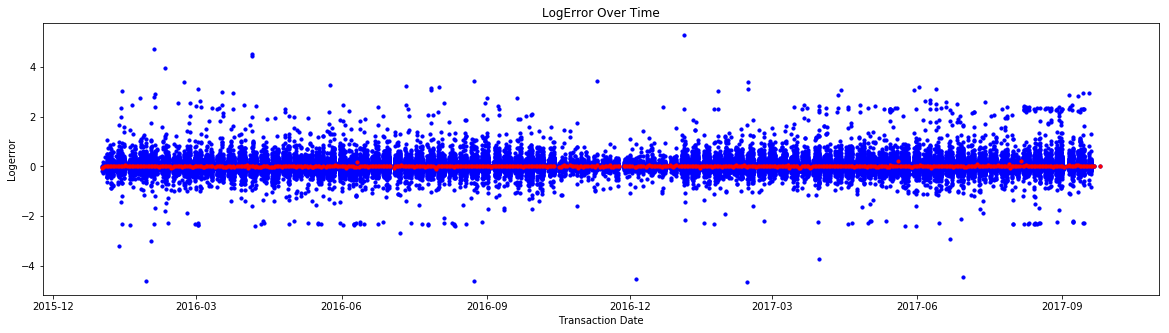

In [12]:
plt.figure(figsize=(20,5))
plt.scatter(df_total['transactiondate'].tolist(), df_total['logerror'], s =10, c = 'blue')
plt.scatter(means.index, means, s =10, c = 'red')
plt.title('LogError Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Logerror')
plt.show()

# Missing Data and Outliers

In [ ]:
missing_percents = (len(df_total.index) - df_total.count())/len(df_total.index)

In [ ]:
missing_percents.sort_values(inplace=True)

In [ ]:
missing_percents.plot(kind='barh', figsize=(20,30))
plt.yticks(size=20)
plt.show()

### Lets also look at this by year to make sure the two sets don't have major differences

In [13]:
missing_percents16 = (len(df_merged16.index) - df_merged16.count())/len(df_merged16.index)
missing_percents17 = (len(df_merged17.index) - df_merged17.count())/len(df_merged17.index)

In [14]:
missing_percents16.sort_values(inplace=True)
temp = pd.DataFrame(missing_percents17, columns=['2017'])
missing_combined = pd.DataFrame(missing_percents16, columns=['2016'])
missing_combined = missing_combined.join(temp)

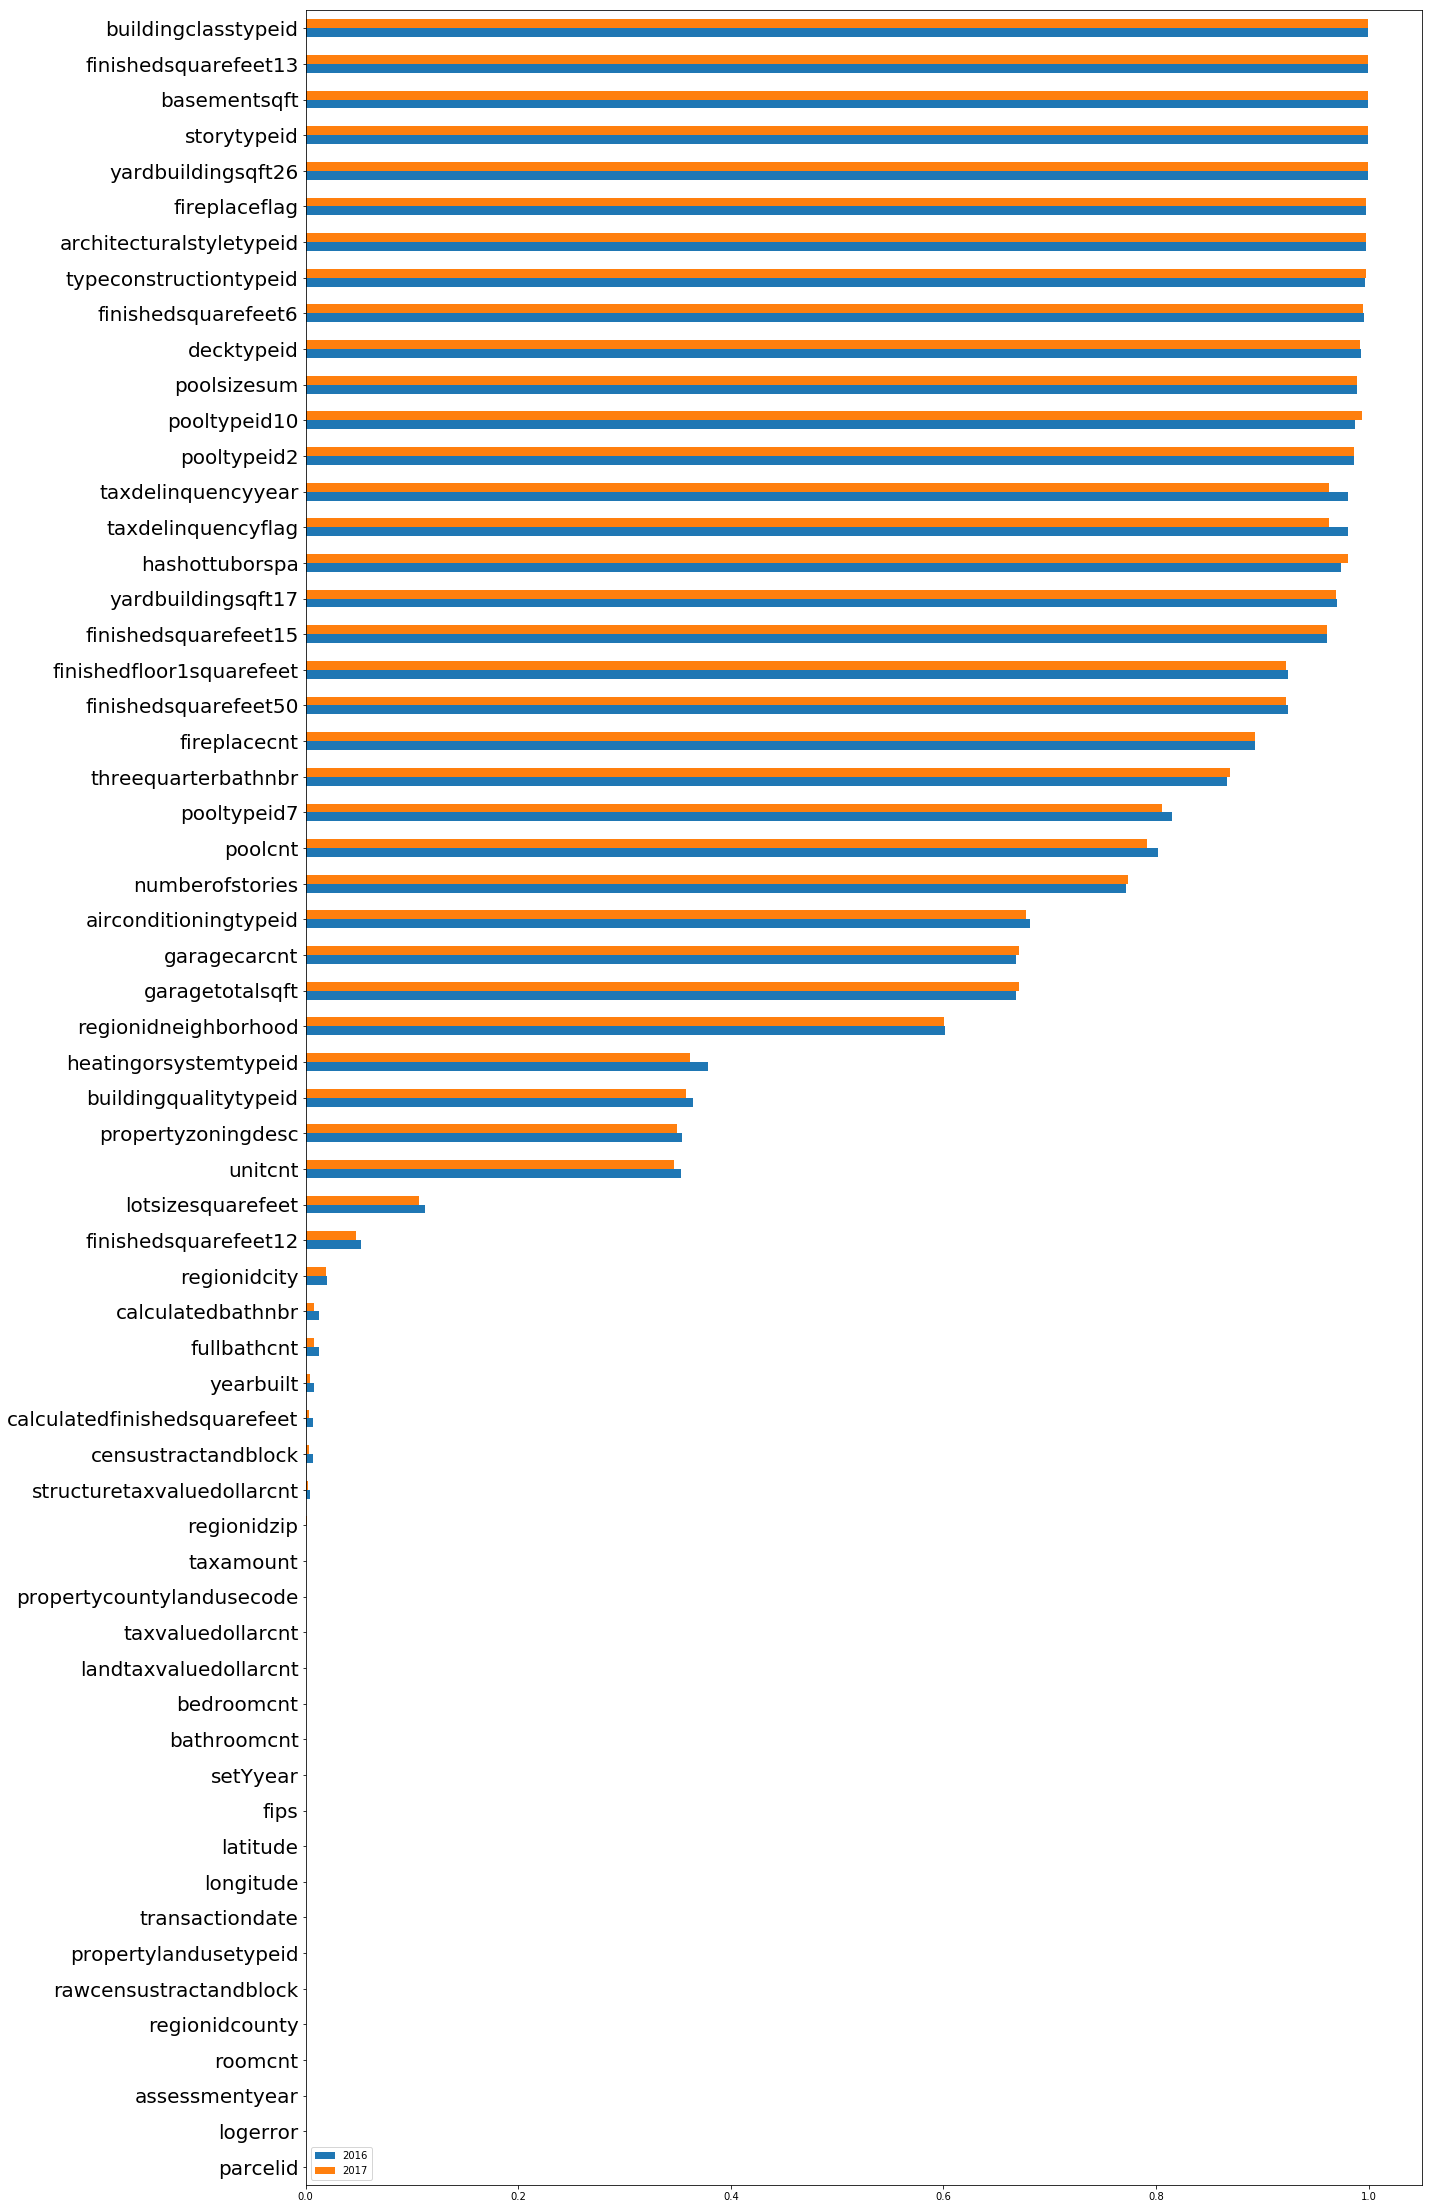

In [15]:
missing_combined.plot.barh(figsize=(20,40))
plt.yticks(size=20)
plt.show()

# Outlier Analysis

In [17]:
categorical=['airconditioningtypeid','architecturalstyletypeid','buildingclasstypeid','decktypeid','fips',
             'hashottuborspa','heatingorsystemtypeid','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc',
             'rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip',
             'storytypeid','typeconstructiontypeid','fireplaceflag','taxdelinquencyflag','censustractandblock',
             'transactiondate']
numerical = ['basementsqft','bathroomcnt','bedroomcnt','buildingqualitytypeid','calculatedbathnbr',
             'finishedfloor1squarefeet','calculatedfinishedsquarefeet','finishedsquarefeet12',
             'finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6',
             'fireplacecnt','fullbathcnt','garagecarcnt','garagetotalsqft','latitude','longitude',
             'lotsizesquarefeet','poolcnt','poolsizesum','pooltypeid10','pooltypeid2','pooltypeid7','roomcnt',
             'threequarterbathnbr','unitcnt','yardbuildingsqft17','yardbuildingsqft26','yearbuilt','numberofstories',
             'structuretaxvaluedollarcnt','taxvaluedollarcnt','assessmentyear','landtaxvaluedollarcnt','taxamount',
             'taxdelinquencyyear','logerror']

# Ignore: parcelid, setyear

rooms = ['bathroomcnt','bedroomcnt','calculatedbathnbr','fullbathcnt','roomcnt','threequarterbathnbr']
sqft = ['basementsqft','finishedfloor1squarefeet','calculatedfinishedsquarefeet','finishedsquarefeet12',
        'finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6',
        'garagetotalsqft']
lotsqft=['lotsizesquarefeet']
yard=['yardbuildingsqft17','yardbuildingsqft26']
pools=['poolcnt','pooltypeid10','pooltypeid2','pooltypeid7']
poolsz = 'poolsizesum'
features = ['buildingqualitytypeid','fireplacecnt','garagecarcnt','numberofstories']
units= ['unitcnt']
taxes=['structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount']
years = ['yearbuilt','assessmentyear','taxdelinquencyyear']

## 2017 Outliers

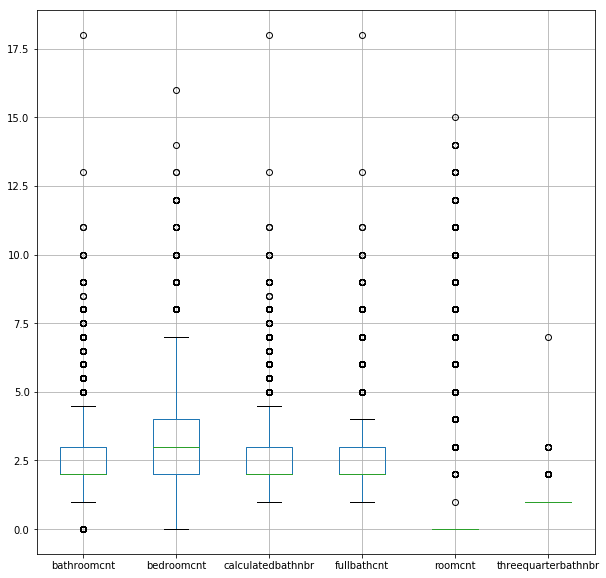

In [49]:
df_merged17.boxplot(rooms, figsize=(10,  10))
plt.show()

In [ ]:
df_merged17.boxplot(sqft, figsize=(20,  10))
plt.show()

In [ ]:
df_merged17.boxplot(lotsqft)

plt.show()

In [ ]:
df_merged17.boxplot(pools)

plt.show()

In [ ]:
df_merged17.boxplot(poolsz)

plt.show()

In [ ]:
df_merged17.boxplot(features)

plt.show()

In [ ]:
df_merged17.boxplot(yard)

plt.show()

In [ ]:
df_merged17.boxplot(misc)

plt.show()

In [ ]:
df_merged17.boxplot(taxes)

plt.show()

In [ ]:
df_merged17.boxplot(years)

plt.show()

In [18]:
outliers1=df_merged17[df_merged17['calculatedbathnbr'] > 12]

In [92]:
outliers2 = df_merged17[df_merged17['unitcnt'] > 20]
outliers2

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,setyear
17201,14078517,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3472.0,NaN,NaN,NaN,NaN,3472.0,6059.0,NaN,NaN,NaN,NaN,NaN,NaN,33.719638,-118.040939,6314.0,NaN,NaN,NaN,NaN,NaN,135,247.0,NaN,6.059099e+07,25218.0,1286.0,NaN,96967.0,0.0,NaN,NaN,NaN,237.0,NaN,NaN,1977.0,2.0,NaN,194788.0,1045707.0,2016.0,850919.0,11980.72,NaN,NaN,6.059099e+13,-0.006891,2017-04-11,2017
42480,11789988,NaN,NaN,NaN,0.0,0.0,4.0,8.0,NaN,NaN,NaN,10422.0,NaN,NaN,10422.0,NaN,NaN,6037.0,NaN,NaN,NaN,NaN,NaN,NaN,34.064906,-118.270121,19265.0,NaN,NaN,NaN,NaN,NaN,1720,31.0,LAC2,6.037208e+07,12447.0,3101.0,276023.0,96038.0,0.0,NaN,NaN,NaN,42.0,NaN,NaN,1941.0,1.0,NaN,140326.0,561320.0,2016.0,420994.0,8409.26,NaN,NaN,6.037208e+13,0.202751,2017-02-27,2017
63827,14013083,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3709.0,NaN,NaN,NaN,NaN,3709.0,6059.0,NaN,NaN,0.0,0.0,NaN,NaN,33.823043,-118.010529,8838.0,NaN,NaN,NaN,NaN,NaN,96,248.0,NaN,6.059110e+07,16764.0,1286.0,118872.0,97023.0,0.0,NaN,NaN,NaN,45.0,NaN,NaN,1961.0,2.0,NaN,146658.0,329438.0,2016.0,182780.0,4754.76,NaN,NaN,6.059110e+13,-0.003095,2017-01-31,2017


In [26]:
outliers3 = df_merged17[df_merged17['lotsizesquarefeet'] > 2000000]

In [28]:
outliers17 = outliers1.append(outliers2)
outliers17 = outliers17.append(outliers3)
pd.set_option('display.max_columns', 65)
outliers17

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,setyear
45820,11645106,1.0,NaN,NaN,18.0,14.0,NaN,12.0,18.0,NaN,NaN,18654.0,18654.0,NaN,NaN,NaN,NaN,6037.0,NaN,18.0,NaN,NaN,NaN,2.0,34.082462,-118.446878,NaN,1.0,NaN,NaN,NaN,1.0,0101,261.0,LARE40,6.037262e+07,12447.0,3101.0,113688.0,96058.0,0.0,NaN,NaN,NaN,2.0,NaN,NaN,1927.0,NaN,NaN,109038.0,49061236.0,2016.0,48952198.0,586639.30,NaN,NaN,6.037262e+13,0.448665,2017-02-08,2017
54022,11655139,1.0,NaN,NaN,13.0,7.0,NaN,NaN,13.0,NaN,NaN,20612.0,20612.0,NaN,NaN,NaN,NaN,6037.0,NaN,13.0,NaN,NaN,NaN,2.0,34.114173,-118.420107,233585.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LARE40,6.037261e+07,12447.0,3101.0,113749.0,96086.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1994.0,NaN,NaN,9164901.0,12386870.0,2016.0,3221969.0,149026.60,NaN,NaN,6.037261e+13,0.013138,2017-04-07,2017
17201,14078517,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3472.0,NaN,NaN,NaN,NaN,3472.0,6059.0,NaN,NaN,NaN,NaN,NaN,NaN,33.719638,-118.040939,6314.0,NaN,NaN,NaN,NaN,NaN,135,247.0,NaN,6.059099e+07,25218.0,1286.0,NaN,96967.0,0.0,NaN,NaN,NaN,237.0,NaN,NaN,1977.0,2.0,NaN,194788.0,1045707.0,2016.0,850919.0,11980.72,NaN,NaN,6.059099e+13,-0.006891,2017-04-11,2017
733,11006663,1.0,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2615.0,2615.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34.311237,-118.403188,3589145.0,NaN,NaN,NaN,NaN,NaN,01DC,266.0,LARD6,6.037106e+07,12447.0,3101.0,34213.0,96368.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,2002.0,NaN,NaN,243466.0,405327.0,2016.0,161861.0,4931.23,NaN,NaN,6.037106e+13,0.040221,2017-03-30,2017
1967,11241323,NaN,NaN,NaN,2.0,2.0,NaN,8.0,2.0,NaN,NaN,1932.0,1932.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,NaN,34.487900,-118.172000,6971010.0,NaN,NaN,NaN,NaN,NaN,010M,261.0,LCA11*,6.037911e+07,16677.0,3101.0,NaN,97298.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1998.0,NaN,NaN,221200.0,295000.0,2016.0,73800.0,3510.02,NaN,NaN,6.037911e+13,-0.020050,2017-04-27,2017
5438,11241249,NaN,NaN,NaN,2.0,3.0,NaN,8.0,2.0,NaN,NaN,1782.0,1782.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,NaN,34.487900,-118.172000,6971010.0,NaN,NaN,NaN,NaN,NaN,010M,261.0,LCA11*,6.037911e+07,16677.0,3101.0,NaN,97298.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1990.0,NaN,NaN,190100.0,263500.0,2016.0,73400.0,3225.94,NaN,NaN,6.037911e+13,-0.018096,2017-03-14,2017
9679,11006635,1.0,NaN,NaN,2.0,3.0,NaN,8.0,2.0,NaN,NaN,2118.0,2118.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34.311237,-118.403188,3589145.0,NaN,NaN,NaN,NaN,NaN,01DC,266.0,LARD6,6.037106e+07,12447.0,3101.0,34213.0,96368.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,2002.0,NaN,NaN,223000.0,486000.0,2016.0,263000.0,5937.28,NaN,NaN,6.037106e+13,0.077310,2017-04-14,2017
13133,11006479,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,2340.0,2340.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34.313220,-118.401559,3589145.0,NaN,NaN,NaN,NaN,NaN,01DC,266.0,LARD6,6.037106e+07,12447.0,3101.0,34213.0,96368.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,2001.0,NaN,NaN,206777.0,348161.0,2016.0,141384.0,4313.75,NaN,NaN,6.037106e+13,0.027703,2017-02-07,2017
13164,11241292,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,NaN,NaN,1248.0,1248.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,NaN,34.4

* For the lot size outliers, almost all of them have one of two lot sizes (3589145 or 6971010). This suggests there is something irregular with the values and in our data wrangling we will replace them with the median. 
* The outliers based on bathroom count are consistent in having outliers in most features, and are thus likely mansions in the LA area and accurately refelect the skew of the data. 
* For the unit count outliers, the property land use type id include a triplex, a quadruplex, and a mixed use building. The values are thus most likely data entry errors and we are replacing the values with the median.

## 2016 Outliers

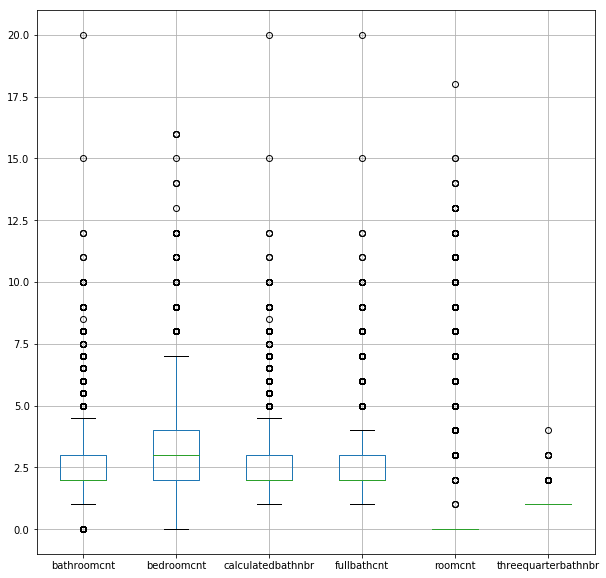

In [50]:
df_merged16.boxplot(rooms, figsize=(10,  10))
plt.show()

In [ ]:
df_merged16.boxplot(sqft, figsize=(20,  10))
plt.show()

In [ ]:
df_merged16.boxplot(lotsqft)

plt.show()

In [ ]:
df_merged16.boxplot(yard)

plt.show()

In [ ]:
df_merged16.boxplot(pools)

plt.show()

In [ ]:
df_merged16.boxplot(poolsz)

plt.show()

In [ ]:
df_merged16.boxplot(features)

plt.show()

In [ ]:
df_merged16.boxplot(misc)

plt.show()

In [ ]:
df_merged16.boxplot(taxes)

plt.show()

In [ ]:
df_merged16.boxplot(years)

plt.show()

In [47]:
outliers4=df_merged16[df_merged16['calculatedbathnbr'] > 10]
outliers4

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,setYyear
9678,11731764,NaN,NaN,NaN,12.0,0.0,NaN,7.0,12.0,NaN,NaN,5878.0,NaN,NaN,5878.0,NaN,NaN,6037.0,NaN,12.0,NaN,NaN,NaN,NaN,34.028850,-118.289063,7500.0,NaN,NaN,NaN,NaN,NaN,0400,248.0,LARD1.5,6.037222e+07,12447.0,3101.0,268540.0,95988.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,2002.0,NaN,NaN,361522.0,660208.0,2015.0,298686.0,8479.29,NaN,NaN,6.037222e+13,-1.2040,2016-06-10,2016
13285,12252718,1.0,NaN,NaN,11.0,15.0,NaN,7.0,11.0,NaN,NaN,6476.0,NaN,NaN,6476.0,NaN,NaN,6037.0,NaN,11.0,NaN,NaN,NaN,NaN,33.916804,-118.288374,13215.0,NaN,NaN,NaN,NaN,NaN,0400,248.0,LAR3,6.037291e+07,12447.0,3101.0,273930.0,96025.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,1926.0,NaN,NaN,149240.0,362440.0,2015.0,213200.0,11533.75,NaN,NaN,6.037291e+13,-0.1696,2016-09-21,2016
42935,11740190,1.0,NaN,NaN,12.0,8.0,NaN,4.0,12.0,NaN,NaN,5440.0,NaN,NaN,5440.0,NaN,NaN,6037.0,NaN,12.0,NaN,NaN,NaN,NaN,34.048620,-118.374399,5999.0,NaN,NaN,NaN,NaN,NaN,0400,248.0,LARD1.5,6.037217e+07,12447.0,3101.0,275024.0,96016.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,2007.0,NaN,NaN,491197.0,909237.0,2015.0,418040.0,15210.01,NaN,NaN,6.037217e+13,-0.0315,2016-03-07,2016
49230,10825953,1.0,NaN,NaN,20.0,3.0,NaN,7.0,20.0,NaN,NaN,66.0,66.0,NaN,NaN,NaN,NaN,6037.0,NaN,20.0,NaN,NaN,NaN,2.0,34.205995,-118.433048,6749.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LAR1,6.037127e+07,12447.0,3101.0,41466.0,96414.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1960.0,NaN,NaN,165069.0,233496.0,2015.0,68427.0,2831.76,NaN,NaN,6.037127e+13,-0.0325,2016-08-31,2016
53272,11670695,1.0,NaN,NaN,11.0,8.0,NaN,10.0,11.0,NaN,NaN,7865.0,7865.0,NaN,NaN,NaN,NaN,6037.0,NaN,11.0,NaN,NaN,NaN,2.0,34.070423,-118.469891,14915.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LARE11,6.037262e+07,12447.0,3101.0,113910.0,96030.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,1399516.0,5340167.0,2015.0,3940651.0,65200.45,NaN,NaN,6.037262e+13,0.1089,2016-07-21,2016
55103,11640165,1.0,NaN,NaN,11.0,7.0,NaN,12.0,11.0,NaN,NaN,11478.0,11478.0,NaN,NaN,NaN,NaN,6037.0,NaN,11.0,NaN,NaN,NaN,2.0,34.089142,-118.408574,33617.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,BHR1*,6.037701e+07,10389.0,3101.0,NaN,96086.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1999.0,NaN,NaN,6192129.0,15389241.0,2015.0,9197112.0,181533.24,NaN,NaN,6.037701e+13,0.2593,2016-04-08,2016
69157,12651118,NaN,NaN,NaN,12.0,8.0,NaN,4.0,12.0,NaN,NaN,4963.0,NaN,NaN,4963.0,NaN,NaN,6037.0,NaN,12.0,NaN,NaN,NaN,NaN,33.736308,-118.297610,5005.0,NaN,NaN,NaN,NaN,NaN,0400,248.0,LARD1.5,6.037297e+07,12447.0,3101.0,54300.0,96221.0,0.0,NaN,NaN,NaN,4.0,NaN,NaN,1986.0,NaN,NaN,433191.0,487548.0,2015.0,54357.0,6310.97,NaN,NaN,6.037297e+13,-0.1381,2016-10-12,2016
87193,11654953,1.0,NaN,NaN,15.0,7.0,NaN,NaN,15.0,NaN,NaN,20013.0,20013.0,NaN,NaN,NaN,NaN,6037.0,NaN,15.0,NaN,NaN,NaN,2.0,34.122666,-118.414718,99022.0,1.0,NaN,NaN,NaN,1.0,0103,261.0,LARE40,6.037261e+07,12447.0,3101.0,113749.0,96086.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,2000.0,NaN,NaN,5355639.0,22411718.0,2015.0,17056079.0,272407.03,NaN,NaN,6.037261e+13,-0.3711,2016-10-20,2016


In [91]:
outliers5 = df_merged16[df_merged16['unitcnt'] > 20]
outliers5

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,setYyear,setyear
9345,12984030,1.0,NaN,NaN,3.0,4.0,NaN,7.0,3.0,NaN,NaN,1928.0,1928.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34.065737,-118.008590,1812.0,NaN,NaN,NaN,NaN,NaN,010D,269.0,EMR3*,6.037433e+07,51861.0,3101.0,NaN,96479.0,0.0,NaN,NaN,NaN,143.0,NaN,NaN,1991.0,NaN,NaN,243856.0,397547.0,2015.0,153691.0,5392.03,NaN,NaN,6.037433e+13,0.0363,2016-04-20,2016,2016
57830,12428342,1.0,NaN,NaN,2.0,3.0,NaN,7.0,2.0,NaN,NaN,1361.0,1361.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,33.843894,-118.084382,14997.0,NaN,NaN,NaN,NaN,NaN,010C,266.0,LKMFR*,6.037555e+07,12292.0,3101.0,NaN,96215.0,0.0,NaN,NaN,NaN,70.0,NaN,NaN,1986.0,NaN,NaN,127497.0,239694.0,2015.0,112197.0,3013.24,NaN,NaN,6.037555e+13,0.0159,2016-08-26,2016,2016


In [35]:
outliers6 = df_merged16[df_merged16['lotsizesquarefeet'] > 2000000]

In [90]:
outliers16 = outliers4.append(outliers5)
outliers16 = outliers16.append(outliers6)
pd.set_option('display.max_columns', 65)
outliers16

,airconditioningtypeid,architecturalstyletypeid,assessmentyear,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,censustractandblock,decktypeid,finishedfloor1squarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fireplaceflag,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,landtaxvaluedollarcnt,latitude,logerror,longitude,lotsizesquarefeet,numberofstories,parcelid,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,setYyear,setyear,storytypeid,structuretaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,taxvaluedollarcnt,threequarterbathnbr,transactiondate,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt
9678,NaN,NaN,2015.0,NaN,12.0,0.0,NaN,7.0,12.0,5878.0,6.037222e+13,NaN,NaN,NaN,NaN,5878.0,NaN,NaN,6037.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,298686.0,34.028850,-1.2040,-118.289063,7500.0,NaN,11731764,NaN,NaN,NaN,NaN,NaN,0400,248.0,LARD1.5,6.037222e+07,12447.0,3101.0,268540.0,95988.0,0.0,2016,NaN,NaN,361522.0,8479.29,NaN,NaN,660208.0,NaN,2016-06-10,NaN,4.0,NaN,NaN,2002.0
13285,1.0,NaN,2015.0,NaN,11.0,15.0,NaN,7.0,11.0,6476.0,6.037291e+13,NaN,NaN,NaN,NaN,6476.0,NaN,NaN,6037.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,213200.0,33.916804,-0.1696,-118.288374,13215.0,NaN,12252718,NaN,NaN,NaN,NaN,NaN,0400,248.0,LAR3,6.037291e+07,12447.0,3101.0,273930.0,96025.0,0.0,2016,NaN,NaN,149240.0,11533.75,NaN,NaN,362440.0,NaN,2016-09-21,NaN,4.0,NaN,NaN,1926.0
42935,1.0,NaN,2015.0,NaN,12.0,8.0,NaN,4.0,12.0,5440.0,6.037217e+13,NaN,NaN,NaN,NaN,5440.0,NaN,NaN,6037.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,418040.0,34.048620,-0.0315,-118.374399,5999.0,NaN,11740190,NaN,NaN,NaN,NaN,NaN,0400,248.0,LARD1.5,6.037217e+07,12447.0,3101.0,275024.0,96016.0,0.0,2016,NaN,NaN,491197.0,15210.01,NaN,NaN,909237.0,NaN,2016-03-07,NaN,4.0,NaN,NaN,2007.0
49230,1.0,NaN,2015.0,NaN,20.0,3.0,NaN,7.0,20.0,66.0,6.037127e+13,NaN,NaN,66.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,20.0,NaN,NaN,NaN,2.0,68427.0,34.205995,-0.0325,-118.433048,6749.0,NaN,10825953,NaN,NaN,NaN,NaN,NaN,0100,261.0,LAR1,6.037127e+07,12447.0,3101.0,41466.0,96414.0,0.0,2016,NaN,NaN,165069.0,2831.76,NaN,NaN,233496.0,NaN,2016-08-31,NaN,1.0,NaN,NaN,1960.0
53272,1.0,NaN,2015.0,NaN,11.0,8.0,NaN,10.0,11.0,7865.0,6.037262e+13,NaN,NaN,7865.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,11.0,NaN,NaN,NaN,2.0,3940651.0,34.070423,0.1089,-118.469891,14915.0,NaN,11670695,1.0,NaN,NaN,NaN,1.0,0101,261.0,LARE11,6.037262e+07,12447.0,3101.0,113910.0,96030.0,0.0,2016,NaN,NaN,1399516.0,65200.45,NaN,NaN,5340167.0,NaN,2016-07-21,NaN,1.0,NaN,NaN,1940.0
55103,1.0,NaN,2015.0,NaN,11.0,7.0,NaN,12.0,11.0,11478.0,6.037701e+13,NaN,NaN,11478.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,11.0,NaN,NaN,NaN,2.0,9197112.0,34.089142,0.2593,-118.408574,33617.0,NaN,11640165,1.0,NaN,NaN,NaN,1.0,0101,261.0,BHR1*,6.037701e+07,10389.0,3101.0,NaN,96086.0,0.0,2016,NaN,NaN,6192129.0,181533.24,NaN,NaN,15389241.0,NaN,2016-04-08,NaN,1.0,NaN,NaN,1999.0
69157,NaN,NaN,2015.0,NaN,12.0,8.0,NaN,4.0,12.0,4963.0,6.037297e+13,NaN,NaN,NaN,NaN,4963.0,NaN,NaN,6037.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,54357.0,33.736308,-0.1381,-118.297610,5005.0,NaN,12651118,NaN,NaN,NaN,NaN,NaN,0400,248.0,LARD1.5,6.037297e+07,12447.0,3101.0,54300.0,96221.0,0.0,2016,NaN,NaN,433191.0,6310.97,NaN,NaN,487548.0,NaN,2016-10-12,NaN,4.0,NaN,NaN,1986.0
87193,1.0,NaN,2015.0,NaN,15.0,7.0,NaN,NaN,15.0,20013.0,6.037261e+13,NaN,NaN,20013.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,15.0,NaN,NaN,NaN,2.0,17056079.0,34.122666,-0.3711,-118.414718,99022.0,NaN,11654953,1.0,NaN,NaN,NaN,1.0,0103,261.0,LARE40,6.037261e+07,12447.0,3101.0,113749.0,96086.0,0.0,2016,NaN,NaN,5355639.0,272407.03,NaN,NaN,22411718.0,NaN,2016-10-20,NaN,1.0,NaN,NaN,2000.0
9345,1.0,NaN,2015.0,NaN,3.0,4.0,NaN,7.0,3.0,1928.0,6.037433e+13,

* For the lot size outliers, they again have the same two values (3589145 or 6971010). In our data wrangling we will replace them with the median. 
* For the outliers based on unit counts, the property landuse type ids are complexes of planned units (269) and condos (266). The data such as room counts appear to be about individual units, so it appears these are sales of individual units and the number of units is for the entire complex. We will replace these with the median.
* For the outliers based on bathroom count, one has irregularities in other columns such as a calculated finished square footage of 66, so we will be removing that one from the data set. 

### Check for other outliers

In [76]:
def lotsclean(x):
    if x == 3589145 or x == 6971010:
        return df_total['lotsizesquarefeet'].median()
    else:
        return x


df_total['lotsizesquarefeet'] = df_total['lotsizesquarefeet'].map(lambda a: lotsclean(a))

In [96]:
def unitsclean(x):
    if x > 20:
        return df_total['unitcnt'].median()
    else: return x


df_total['unitcnt'] = df_total['unitcnt'].map(lambda a: unitsclean(a))

In [78]:
df_total=df_total[df_total['bathroomcnt']<20]

In [94]:
df_total['propertylandusetypeid'].value_counts()

261.0    113077
266.0     42157
246.0      4397
269.0      4281
248.0      1608
247.0      1168
265.0       691
263.0       158
275.0       105
260.0       104
267.0        57
31.0         32
264.0        17
47.0          1
Name: propertylandusetypeid, dtype: int64

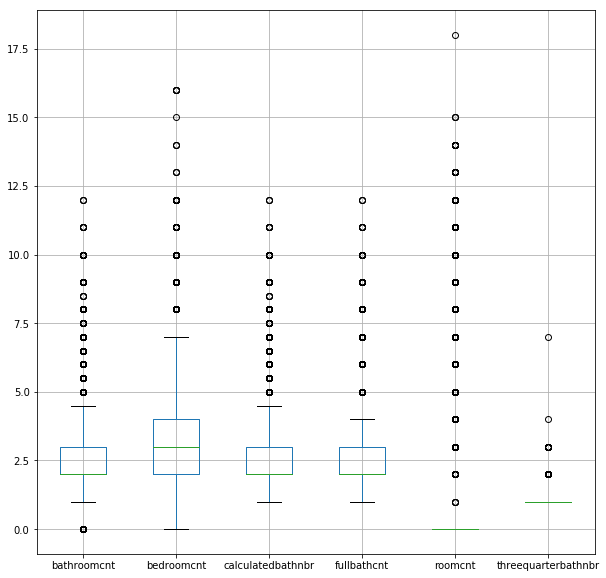

In [48]:
df_total.boxplot(rooms, figsize=(10,  10))
plt.show()

# Over and Under Estimating
Since none of the numerical values have a clear correlation with log error, we want to look to see if the relationship is non-linear by examinging both over and under estimates

(Idea from: https://www.kaggle.com/philippsp/exploratory-analysis-zillow)

In [136]:
numerical = ['bathroomcnt','bedroomcnt','buildingqualitytypeid','calculatedbathnbr',
             'calculatedfinishedsquarefeet','finishedsquarefeet12',
             'fireplacecnt','fullbathcnt','garagecarcnt','garagetotalsqft','latitude','longitude',
             'lotsizesquarefeet','poolcnt','roomcnt','unitcnt','yearbuilt','numberofstories',
              'structuretaxvaluedollarcnt','taxvaluedollarcnt','assessmentyear','landtaxvaluedollarcnt','taxamount',
             'taxdelinquencyyear','logerror']

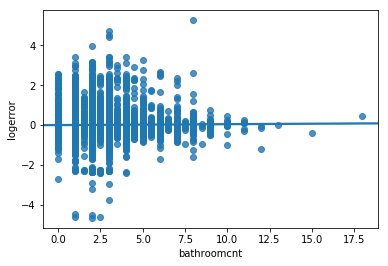

In [126]:
sns.regplot(x=df_total['bathroomcnt'],y=df_total['logerror'])
plt.show()

In [149]:
plt.close()

In [141]:
num = df_total[numerical]

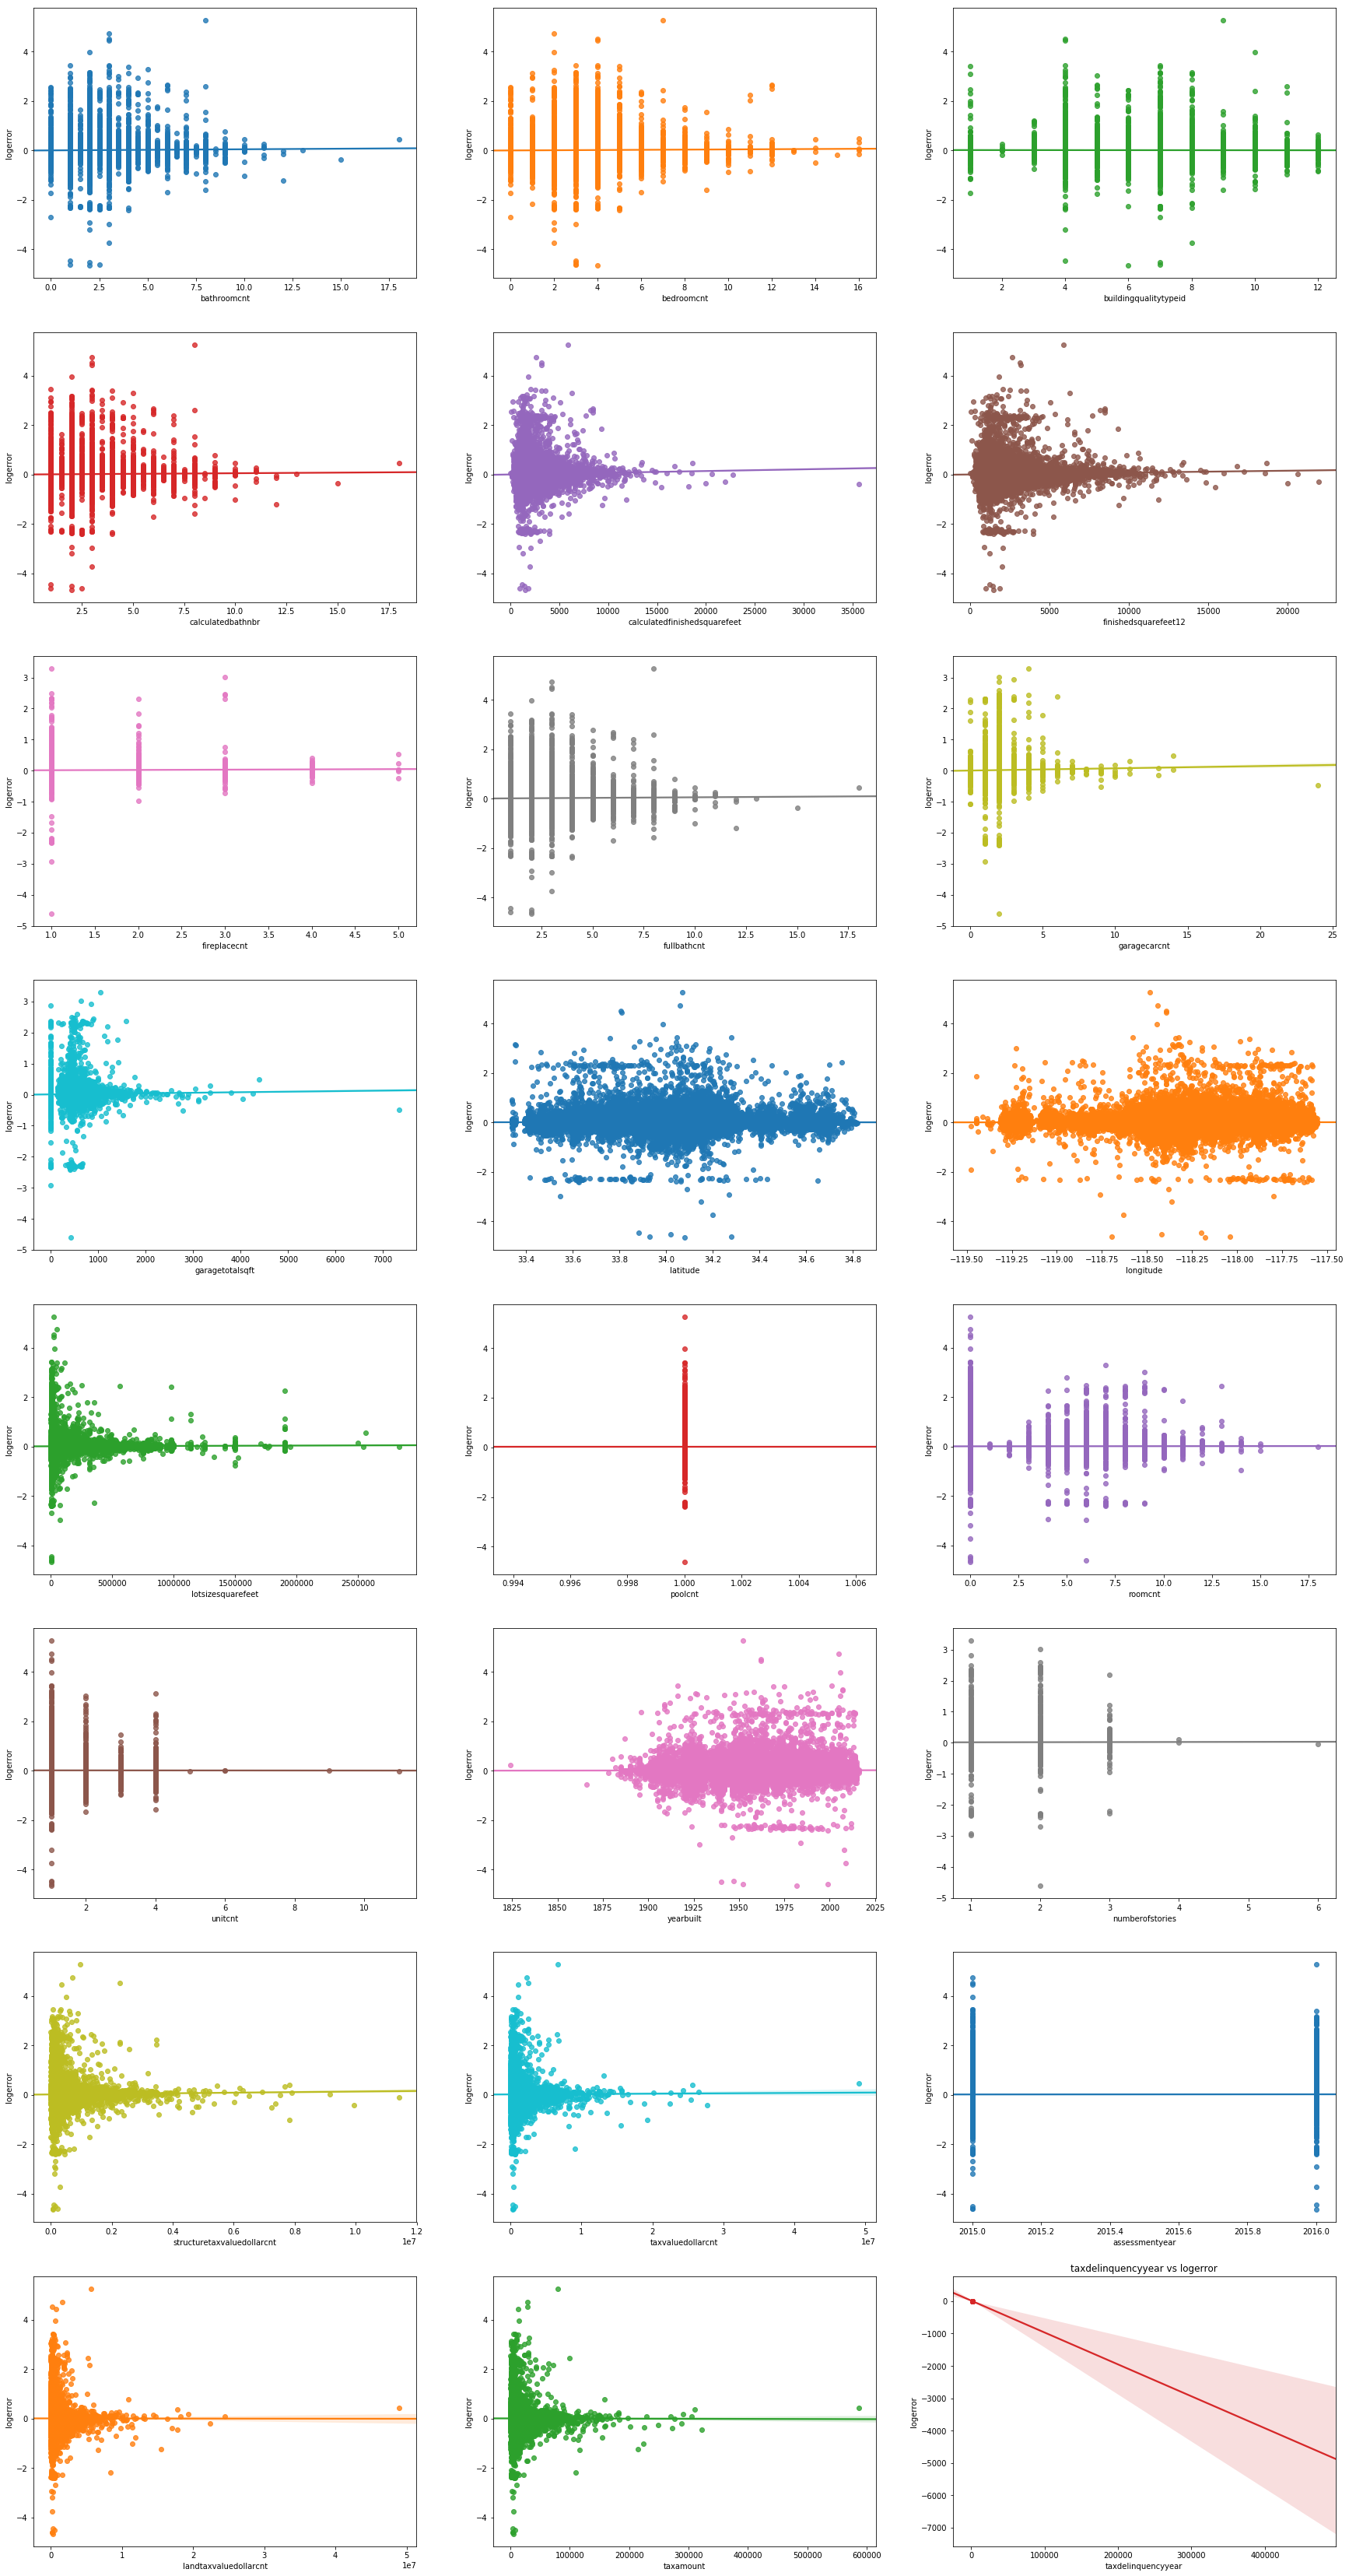

In [150]:
fig, axes = plt.subplots(round(len(num.columns) / 3), 3, figsize=(30, 60))

for i, ax in enumerate(fig.axes):
    if i < len(num):
        sns.regplot(x=num.columns[i], y=num['logerror'], data=num, ax=ax)
        #plt.title(numerical[i] + " vs logerror")
        
plt.show()  

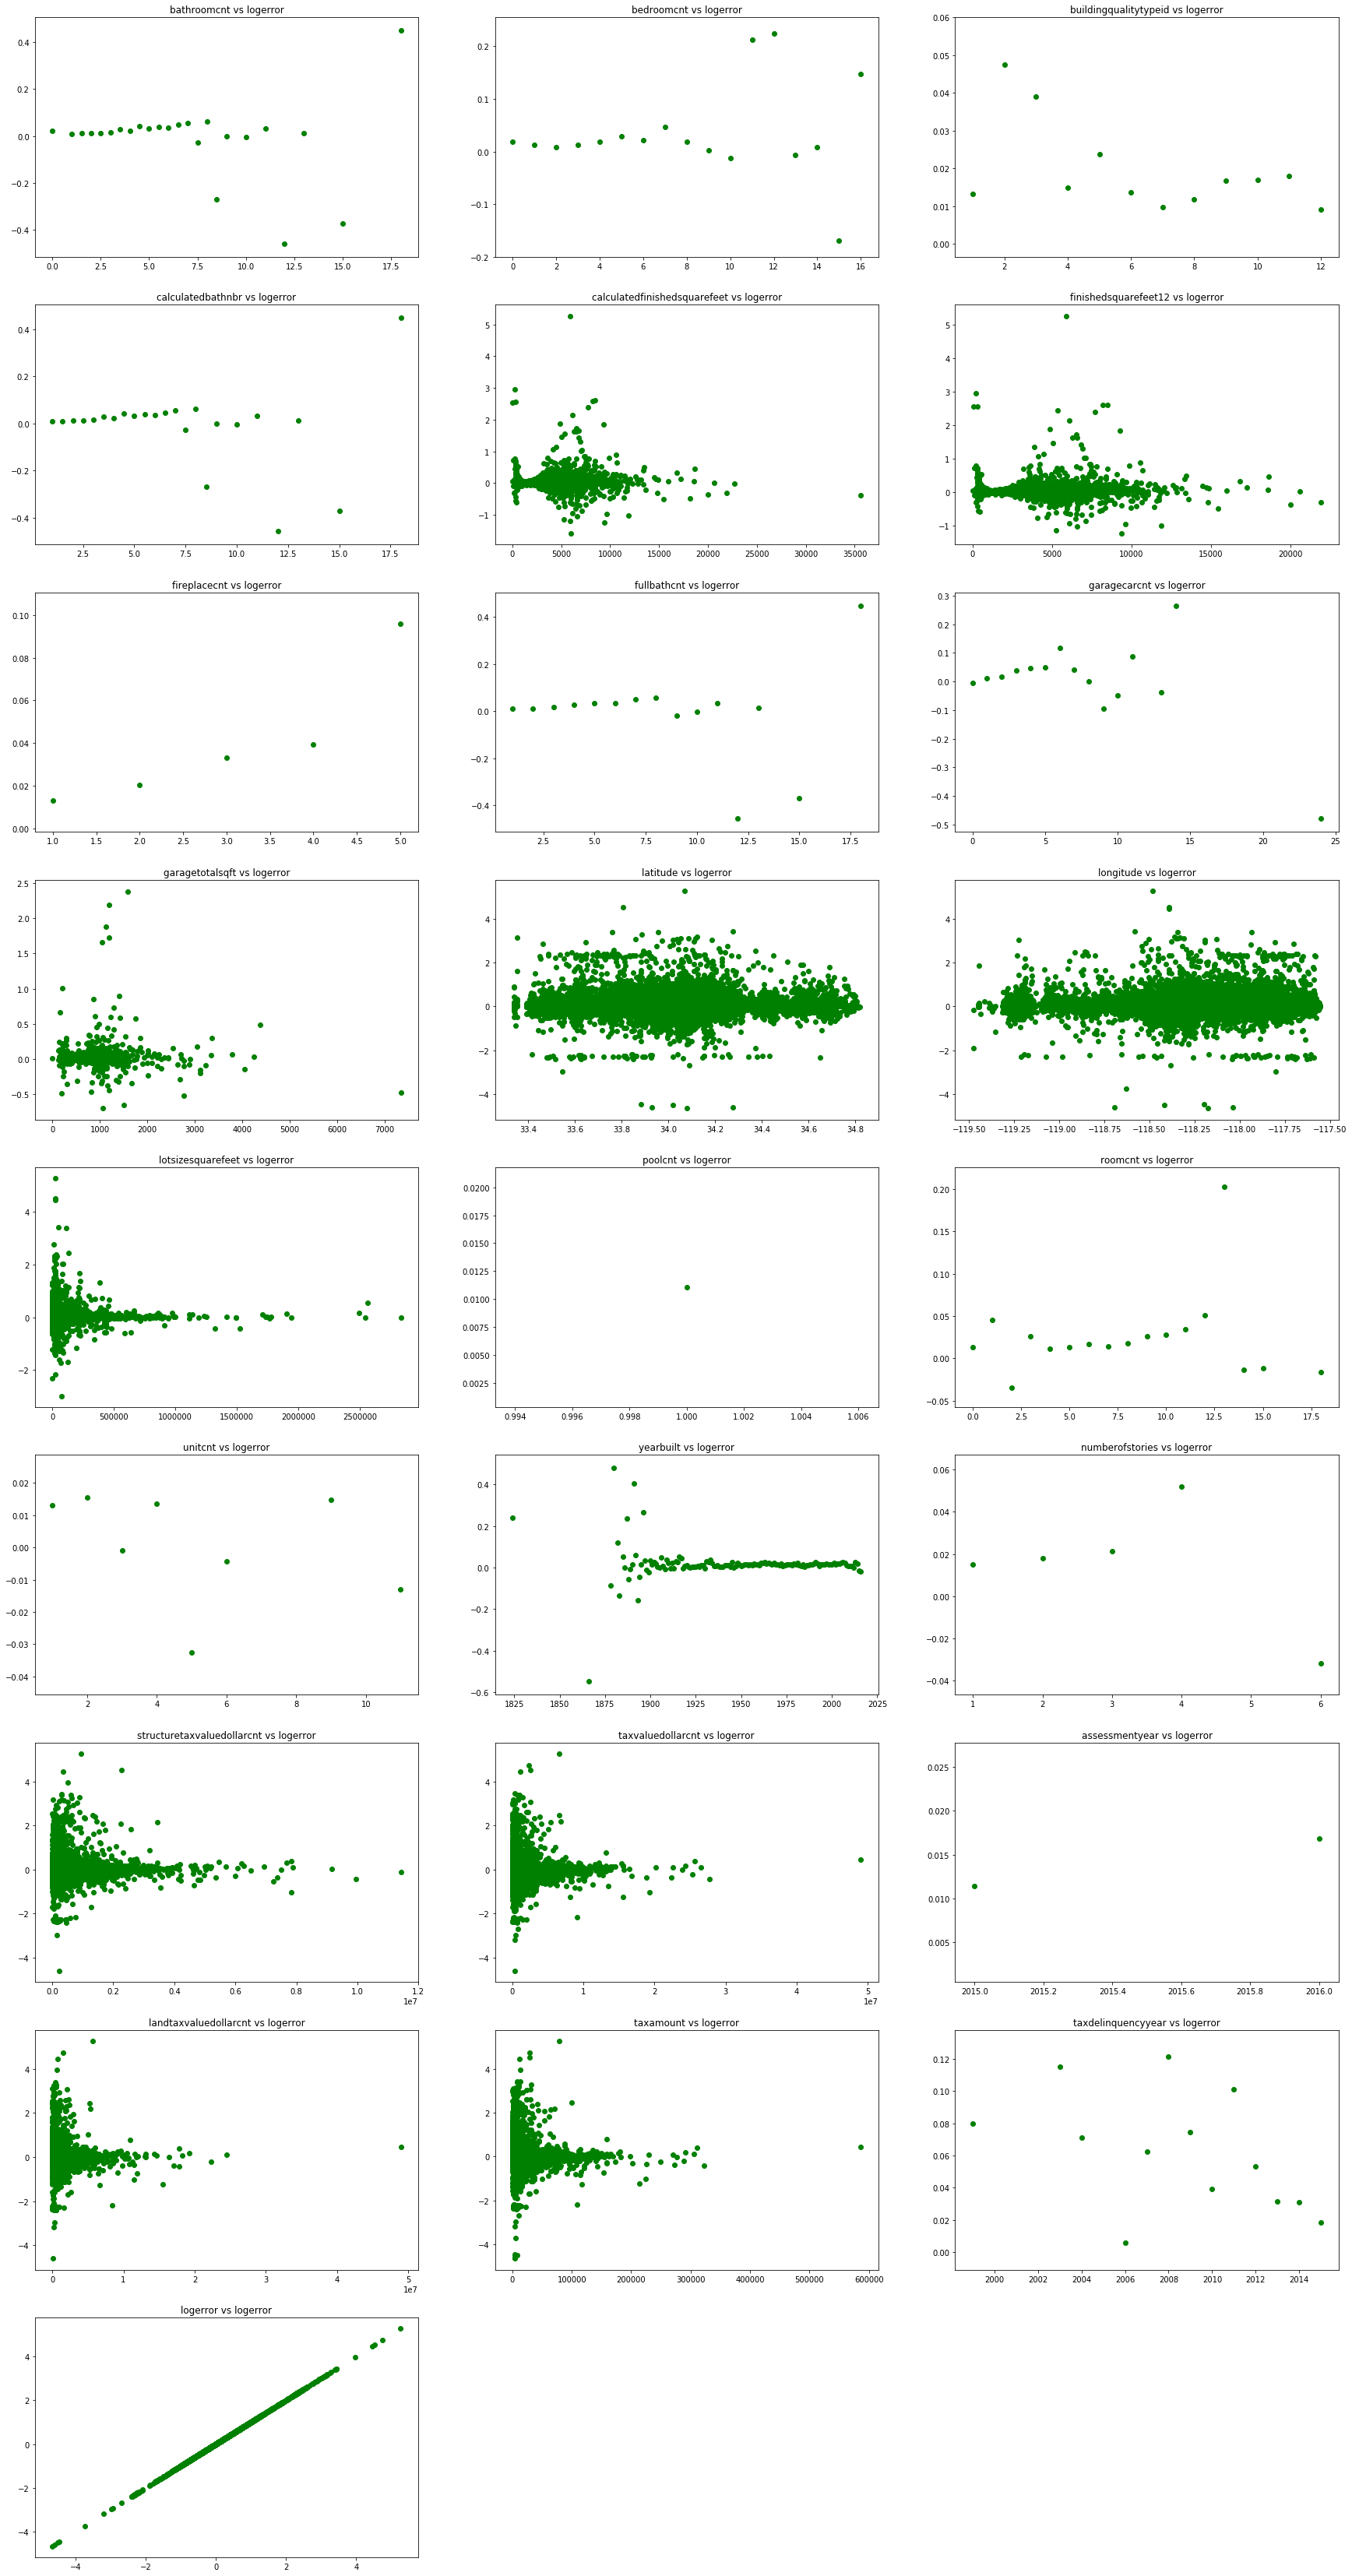

In [140]:
fig = plt.figure(figsize=(30,60))
i = 1
for column in numerical:
    a = df_total.groupby(column)['logerror'].mean()
    sub = fig.add_subplot(9, 3, i)
    sub.scatter(a.index, a, c="g")
    sub.set_title(column + " vs logerror")
    #sub.xlabel(column)
    #sub.ylabel('logerror')
    i+=1

plt.show()

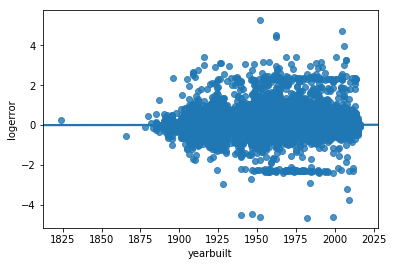

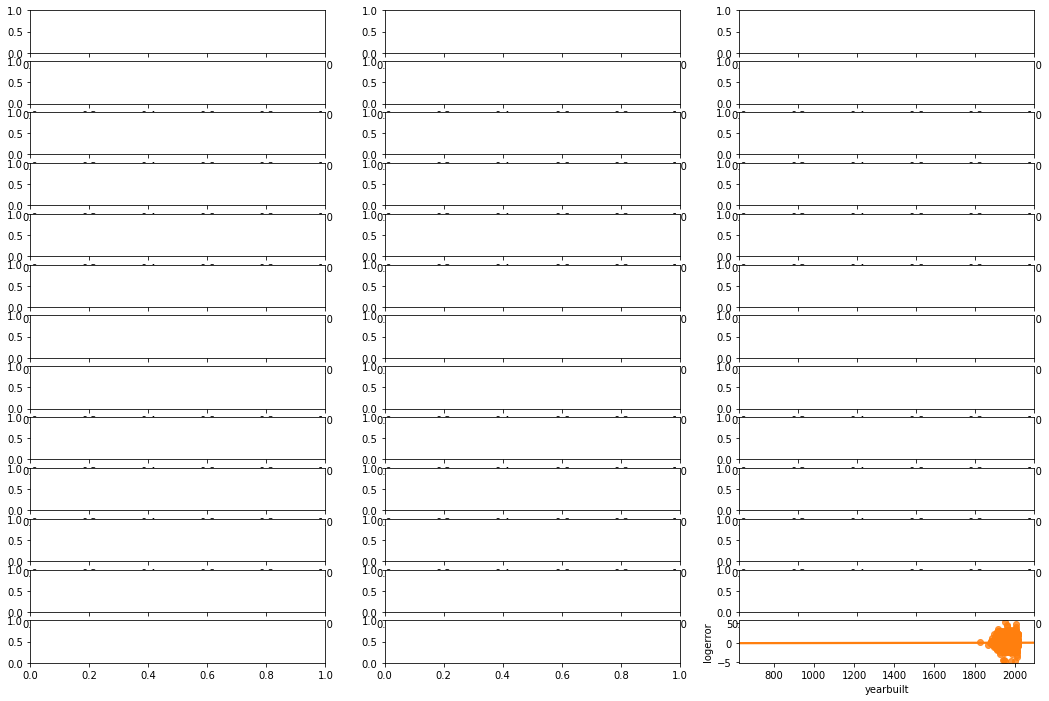

In [113]:
yr = df_total.groupby('yearbuilt')['logerror'].mean()
#plt.scatter(yr.index, yr, c="g")
sns.regplot(x=df_total['yearbuilt'],y=df_total['logerror'])
plt.show()

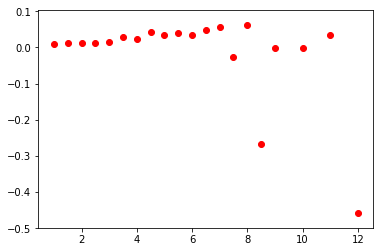

In [56]:
barm = df_total.groupby('calculatedbathnbr')['logerror'].mean()
plt.scatter(barm.index, barm, c="r")
plt.show()

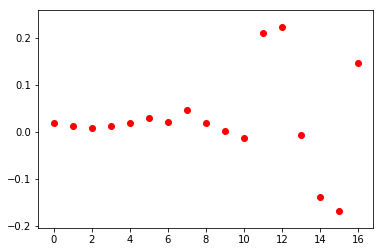

In [57]:
berm = df_total.groupby('bedroomcnt')['logerror'].mean()
plt.scatter(berm.index, berm, c="r")
plt.show()

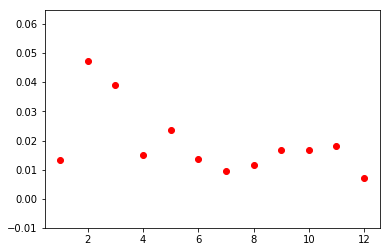

In [58]:
quality = df_total.groupby('buildingqualitytypeid')['logerror'].mean()
plt.scatter(quality.index, quality, c="r")
plt.show()

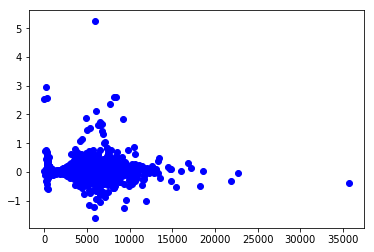

In [61]:
sqft = df_total.groupby('calculatedfinishedsquarefeet')['logerror'].mean()
plt.scatter(sqft.index, sqft, c="b")
plt.show()

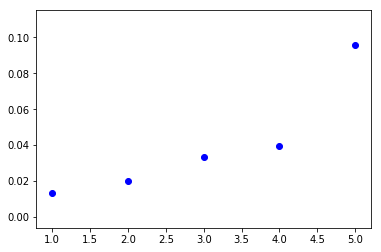

In [62]:
fire = df_total.groupby('fireplacecnt')['logerror'].mean()
plt.scatter(fire.index, fire, c="b")
plt.show()

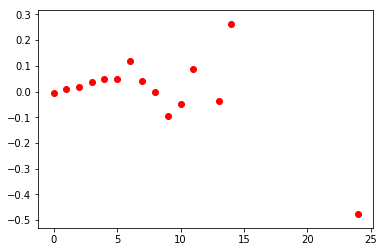

In [63]:
gar = df_total.groupby('garagecarcnt')['logerror'].mean()
plt.scatter(gar.index, gar, c="r")
plt.show()

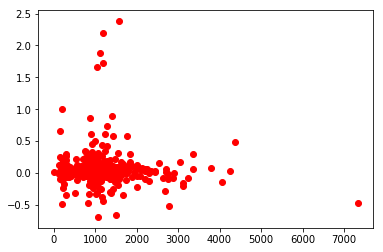

In [64]:
gars = df_total.groupby('garagetotalsqft')['logerror'].mean()
plt.scatter(gars.index, gars, c="r")
plt.show()

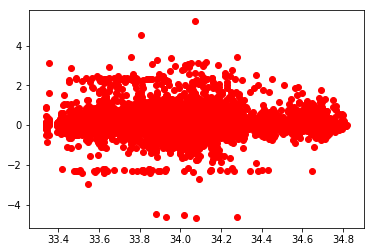

In [66]:
lat = df_total.groupby('latitude')['logerror'].mean()
plt.scatter(lat.index, lat, c="r")
plt.show()

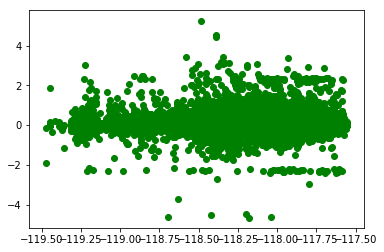

In [67]:
lon = df_total.groupby('longitude')['logerror'].mean()
plt.scatter(lon.index, lon, c="g")
plt.show()
             

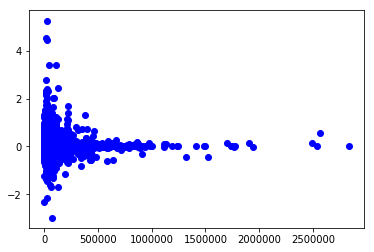

In [81]:
lot = df_total.groupby('lotsizesquarefeet')['logerror'].mean()
plt.scatter(lot.index, lot, c="b")
plt.show()        


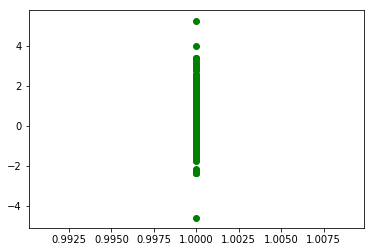

In [85]:
plt.scatter(df_total['poolcnt'], df_total['logerror'], c="g")
plt.show()        


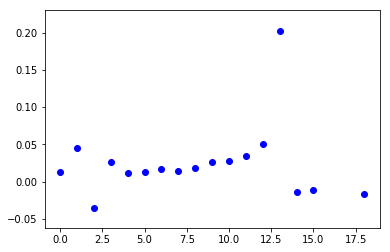

In [87]:
rm = df_total.groupby('roomcnt')['logerror'].mean()
plt.scatter(rm.index, rm, c="b")
plt.show()        

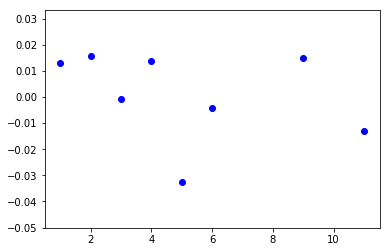

In [97]:
unit = df_total.groupby('unitcnt')['logerror'].mean()
plt.scatter(unit.index, unit, c="b")
plt.show()        

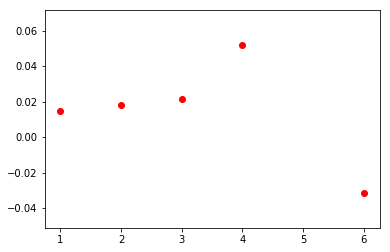

In [98]:
stories = df_total.groupby('numberofstories')['logerror'].mean()
plt.scatter(stories.index, stories, c="r")
plt.show()       

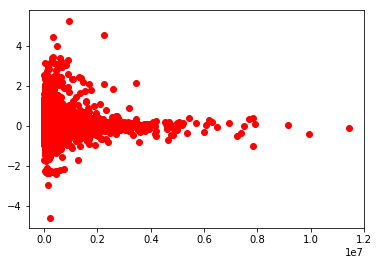

In [99]:
strut = df_total.groupby('structuretaxvaluedollarcnt')['logerror'].mean()
plt.scatter(strut.index, strut, c="r")
plt.show()       

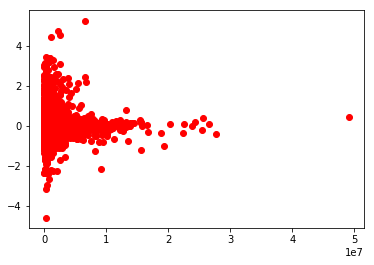

In [100]:
strut = df_total.groupby('taxvaluedollarcnt')['logerror'].mean()
plt.scatter(strut.index, strut, c="r")
plt.show()       

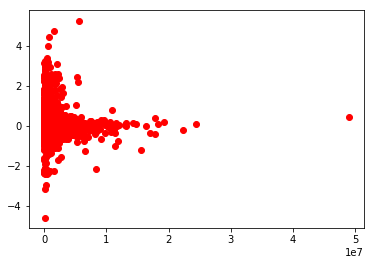

In [101]:
land = df_total.groupby('landtaxvaluedollarcnt')['logerror'].mean()
plt.scatter(land.index, land, c="r")
plt.show()   

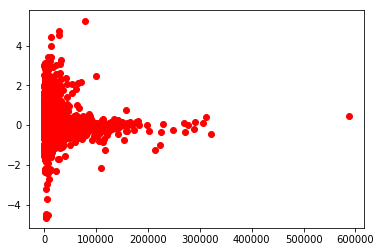

In [102]:
tax = df_total.groupby('taxamount')['logerror'].mean()
plt.scatter(tax.index, tax, c="r")
plt.show()   

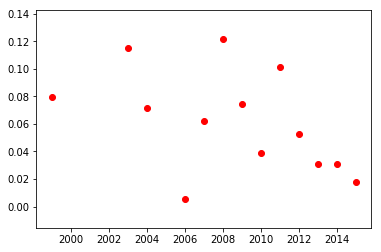

In [103]:
td = df_total.groupby('taxdelinquencyyear')['logerror'].mean()
plt.scatter(td.index, td, c="r")
plt.show()   

# Location Analysis

In [ ]:

# #### Missing Location Information Analysis
# 
# Fields: 
# * regionidzip
# * regionidcity
# * regionidcounty
# * regionidneighborhood
# * fips
# * latitude
# * longitude

df_merged['regionidzip'].describe()


# There appears to be an invalid US zip code for the max. Examine all impossible US zip codes
temp = df_merged[df_merged['regionidzip'] > 100000]

temp['regionidzip']


# All of the entries have the same invalid zip. Look at the county the zip code is associated with.
temp['regionidcounty']


# All have the same county. Get all entries in that county

temp2 = df_merged[df_merged['regionidcounty'] == 3101]
temp2.groupby('regionidzip').count()

temp2['regionidzip'].mode()


# This is not a US zip code. In spot checking, some of these zip codes are from CA, some are from OR, and some don't exist. Look at the other region identifiers:

df_merged.groupby('regionidcounty').count()

df_merged.groupby('regionidcity').count()

df_merged.groupby('regionidneighborhood').count()
df_merged.groupby('fips').count()


# FIPS Codes:
# * 6037: LA County - count is same as county code 3101
# * 6059: Orange County - count is same as county code 1286
# * 6111: Ventura County - count is same as county code 2061
# 
# Verify mapping: 

pd.crosstab(df_merged['fips'],df_merged['regionidcounty'])


# FIPS and RegionIDCounty contain identical information. For feature selection we will use FIPS since it has real-world meaning.

pd.crosstab(df_merged['regionidneighborhood'],df_merged['fips'])

pd.crosstab(df_merged['regionidcity'],df_merged['fips'])

pd.crosstab(df_merged['regionidzip'],df_merged['fips'])


nbcorr = df_merged[df_merged['fips']==6111]


pd.crosstab(nbcorr['regionidneighborhood'],nbcorr['regionidzip'])


# Even though the zip codes are fake, they do correspong to specific collections of neighborhoods, and it thus seems likely that Zillow did a 1:1 substitution when randomizing them. Since neighborhoods are more granular, they will be more useful for analysis.

# #### Latitude and Longitude

df_merged['latitude'].describe()

df_merged['longitude'].describe()



In [152]:
a = df_total.iloc[0]
a

airconditioningtypeid                           NaN
architecturalstyletypeid                        NaN
assessmentyear                                 2015
basementsqft                                    NaN
bathroomcnt                                     2.5
bedroomcnt                                        3
buildingclasstypeid                             NaN
buildingqualitytypeid                           NaN
calculatedbathnbr                               2.5
calculatedfinishedsquarefeet                   1264
censustractandblock                       6.111e+13
decktypeid                                      NaN
finishedfloor1squarefeet                        548
finishedsquarefeet12                           1264
finishedsquarefeet13                            NaN
finishedsquarefeet15                            NaN
finishedsquarefeet50                            548
finishedsquarefeet6                             NaN
fips                                           6111
fireplacecnt

In [155]:
string = str(a['latitude']) + "," + str(a['longitude'])
string

'34.303597,-119.287236'

In [157]:
geolocator = Nominatim()
location = geolocator.reverse(string)
location

Location(Arapaho Street, Ventura, Ventura County, California, 93001, United States of America, (34.304224, -119.288744, 0.0))

In [167]:
location.raw['address']['postcode']

'93001'

In [194]:
#t = ['latitude','longitude']
#test = df_total[t].head()

import time

def zipcalc(a, b):
    geolocator = Nominatim()
    string = str(a) + "," + str(b)
    location = geolocator.reverse(string)
    try:
        return location.raw['address']['postcode']
    except KeyError:
        return np.nan
    except GeocoderTimedOut:
        time.sleep(2)
        zipcalc(a, b)

    
#df_total['regionidzip'] = df_total.apply(lambda x: zipcalc(x['latitude'], x['longitude']), axis=1)



n = 0
for i, row in df_total.iterrows():
    n+=1
    if n == 100:
        time.sleep(1)
        n = 0
    row['regionidzip'] = zipcalc(row['latitude'], row['longitude'])



GeocoderServiceError: HTTP Error 429: Too Many Requests

In [180]:
from pyzipcode import ZipCodeDatabase
zcdb = ZipCodeDatabase()
zcdb.find_zip(latitude=a['latitude']))


,latitude,longitude,regionidzip
0,34.303597,-119.287236,93001
1,34.272866,-119.198911,93009
2,34.340801,-119.079610,93060
3,34.354313,-119.076405,93060
4,34.266578,-119.165392,93004


33.984600    107
33.665651     79
34.056700     61
33.785200     61
33.766300     59
33.667397     53
34.225100     53
34.150100     53
33.578836     52
33.603000     51
34.410700     49
34.150700     48
34.048000     47
33.771600     45
34.171800     45
34.150000     45
34.056400     43
33.771300     43
33.883516     43
34.093400     41
34.045800     41
34.044900     40
34.169800     40
34.041700     39
34.062900     39
33.954400     39
34.150800     39
33.765900     38
33.980000     38
34.177900     37
            ... 
33.879762      1
33.971220      1
34.151802      1
33.941914      1
34.176574      1
34.029940      1
34.279101      1
34.411490      1
33.468192      1
34.059438      1
33.341300      1
34.076046      1
33.797062      1
34.157087      1
34.305033      1
33.872518      1
33.504395      1
33.949112      1
33.991418      1
33.907496      1
34.274803      1
34.395616      1
34.225304      1
33.484221      1
34.104491      1
33.766482      1
34.388805      1
34.416561     

In [205]:

search = ZipcodeSearchEngine()
b = search.by_coordinate(a['latitude'],a['longitude'])
b[0].Zipcode

'93001'

In [21]:
df_merged17 = df_merged17.dropna(subset=['latitude'])
df_merged17 = df_merged17.dropna(subset=['longitude'])
df_merged17['latitude'] = df_merged17['latitude'] / 1000000
df_merged17['longitude'] = df_merged17['longitude'] / 1000000

In [22]:
from uszipcode import ZipcodeSearchEngine

search = ZipcodeSearchEngine()

zips = pd.DataFrame(columns=['parcelid','calczip'])
temp = df_merged17.head()
temp['latitude']

0    34.449407
1    34.454169
2    34.365693
3    34.305600
4    34.278012
Name: latitude, dtype: float64

In [25]:
for i, row in df_merged17.iterrows():
    b = search.by_coordinate(row['latitude'],row['longitude'])
    zips.loc[len(zips)] = [row['parcelid'],b[0].Zipcode] 

In [29]:
zips['calczip'].max()

'93591'

In [34]:
df_merged17['poolcnt'].fillna(0, inplace=True)
df_merged17['pooltypeid10'].fillna(0, inplace=True)
df_merged17['pooltypeid2'].fillna(0, inplace=True)
df_merged17['pooltypeid7'].fillna(0, inplace=True)
df_merged17['hashottuborspa'].fillna(False, inplace=True)



In [39]:
pd.crosstab(df_merged17['pooltypeid10'],df_merged17['pooltypeid2'],df_merged17['pooltypeid7'])

ValueError: values cannot be used without an aggfunc.

In [42]:
pools=['poolcnt','pooltypeid2','pooltypeid7','pooltypeid10','hashottuborspa']
df_temp = df_merged17[pools]

In [43]:
df_temp.head()

,poolcnt,pooltypeid2,pooltypeid7,pooltypeid10,hashottuborspa
0,1.0,NaN,1.0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [47]:
df_temp2 = df_merged17[pools].dropna(subset=['poolcnt'])
df_temp2['pooltypeid10'].fillna(0, inplace=True)
df_temp2['pooltypeid2'].fillna(0, inplace=True)
df_temp2['pooltypeid7'].fillna(0, inplace=True)
df_temp2['hashottuborspa'].fillna(False, inplace=True)

In [48]:
df_temp2.head()

,poolcnt,pooltypeid2,pooltypeid7,pooltypeid10,hashottuborspa
0,1.0,0.0,1.0,0.0,False
11,1.0,0.0,1.0,0.0,False
23,1.0,0.0,1.0,0.0,False
27,1.0,0.0,1.0,0.0,False
28,1.0,0.0,1.0,0.0,False


In [50]:
df_temp2.groupby('pooltypeid7')['pooltypeid2'].value_counts()

pooltypeid7  pooltypeid2
0.0          1.0             1074
             0.0               21
1.0          0.0            15079
Name: pooltypeid2, dtype: int64

In [51]:
df_temp2.groupby('pooltypeid7')['pooltypeid10'].value_counts()

pooltypeid7  pooltypeid10
0.0          0.0              1095
1.0          0.0             15079
Name: pooltypeid10, dtype: int64

In [62]:
pd.crosstab(df_temp2['pooltypeid10'],df_temp2['pooltypeid2'])

pooltypeid2,0.0,1.0
pooltypeid10,,
0.0,15100,1074


In [63]:
df_temp2['pooltypeid10'].value_counts()

0.0    16174
Name: pooltypeid10, dtype: int64

In [64]:
df_merged17['pooltypeid10'].value_counts()

1.0    465
Name: pooltypeid10, dtype: int64

In [68]:
df_merged17.groupby('poolcnt')['pooltypeid10'].value_counts()

poolcnt  pooltypeid10
0.0      1.0             465
Name: pooltypeid10, dtype: int64

In [74]:
df_merged17['pooltypeid2'].fillna(0, inplace=True)

In [69]:
df_merged17.groupby('poolcnt')['pooltypeid2'].value_counts()

poolcnt  pooltypeid2
1.0      1.0            1074
Name: pooltypeid2, dtype: int64

In [70]:
df_merged17.groupby('poolcnt')['pooltypeid7'].value_counts()

poolcnt  pooltypeid7
1.0      1.0            15079
Name: pooltypeid7, dtype: int64

In [73]:
df_merged17.groupby('pooltypeid7')['pooltypeid2'].value_counts()

pooltypeid7  pooltypeid2
0.0          1.0            1074
Name: pooltypeid2, dtype: int64

In [75]:
df_merged17.groupby('pooltypeid2')['pooltypeid10'].value_counts()

pooltypeid2  pooltypeid10
0.0          1.0             465
Name: pooltypeid10, dtype: int64

In [76]:
df_merged17.groupby('hashottuborspa')['pooltypeid2'].value_counts()

hashottuborspa  pooltypeid2
True            1.0            1074
                0.0             465
Name: pooltypeid2, dtype: int64

In [77]:
df_merged17['hashottuborspa'].fillna(False, inplace=True)

In [78]:
# fill poolcnt na, fill hashottuborspa na

pools = pd.DataFrame(columns=['parcelid','pooltype'])
        
for i, row in df_merged17.iterrows():
    if row['hashottuborspa'] and row['poolcnt'] > 0:
        pools.loc[len(pools)] = [row['parcelid'],1] 
    elif not(row['hashottuborspa']) and row['poolcnt'] > 0:
        pools.loc[len(pools)] = [row['parcelid'],2] 
    elif row['hashottuborspa'] and row['poolcnt'] == 0:
        pools.loc[len(pools)] = [row['parcelid'],3] 
    else:
        pools.loc[len(pools)] = [row['parcelid'],0] 

In [80]:
#for i, row in df_merged17.iterrows():
#    if row['pooltypeid2'] = 1:
#        row['hashottuborspa'] == True
df_merged17['pooltypeid2'].fillna(0, inplace=True)
df_merged17.groupby('pooltypeid2')['hashottuborspa'].value_counts()

pooltypeid2  hashottuborspa
0.0          False             76074
             True                465
1.0          True               1074
Name: hashottuborspa, dtype: int64

In [84]:
pools['pooltype'].value_counts()

0    60974
2    15100
1     1074
3      465
Name: pooltype, dtype: int64

In [87]:
df_merged17.groupby('propertylandusetypeid')['propertycountylandusecode'].value_counts()

propertylandusetypeid  propertycountylandusecode
31.0                   1720                            7
                       1210                            6
                       1722                            2
246.0                  0200                         1847
                       38                             94
                       1210                           36
                       0201                           23
                       1222                           16
                       0203                            1
                       0204                            1
                       020E                            1
                       020G                            1
                       020M                            1
247.0                  0300                          485
                       135                            38
                       1310                            8
                       1333            

In [89]:
df_merged17['propertyzoningdesc'].value_counts()

LAR1          6766
LAR3          2450
LARS          1394
LBR1N         1225
LARD1.5       1132
LAR2          1033
SCUR2          957
LARD2          852
LARA           654
LARE11         629
LARE15         571
TORR-LO        545
LCR1YY         494
SCUR3          462
LAR4           410
LKR1YY         381
LARD3          374
PSR6           346
LCR1*          310
LCA11*         300
LCA22*         292
GLR1YY         288
PDR1*          287
CARS*          253
LAC2           251
LCA21*         244
BUR1YY         241
MNRS           230
LBR2N          224
NOR1YY         220
              ... 
SRR1L1           1
LOMC-R1*         1
LCRAVV           1
CCR1Z*           1
SPR2B10000       1
DOR 2&HFB        1
LR7000           1
LCR101           1
POOP*            1
LCA101           1
PDC4             1
LBPD3            1
LRR16500         1
AHRS-2-200       1
CVM1YY           1
PDRI             1
DOR105*          1
R7000            1
LBCO*            1
LRRI*            1
GLRA*            1
LNC4YY      